# Principal Component Analysis Assignment

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Import the [PitchFX data set](https://docs.google.com/spreadsheets/d/1pmBtSw7v_tU_dIX1-4E8_Q7wC43fDs6LGDQzN49-ffk/export?format=csv).

In [2]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1pmBtSw7v_tU_dIX1-4E8_Q7wC43fDs6LGDQzN49-ffk/export?format=csv')
print(data.shape)
data.head()

(79931, 35)


,gameString,gameDate,visitor,home,inning,side,balls,strikes,outs,batterId,batterName,batterHand,batterPosition,pitcherId,pitcherName,pitcherHand,timesFaced,catcherId,catcher,umpireId,umpire,probCalledStrike,pitchResult,pitchType,releaseVelocity,spinRate,spinDir,locationHoriz,locationVert,movementHoriz,movementVert,battedBallType,battedBallAngle,battedBallDistance,paResult
0,gid_2016_04_04_sfnmlb_milmlb_1,2016-04-04,SF,MIL,1,T,0,0,0,452655,Denard Span,L,CF,503449,Wily Peralta,R,1,518960,Jonathan Lucroy,427192,Brian Gorman,0.975,SL,FF,94.2,2044.22,205.477,-0.374,2.933,-6.93,8.28,NaN,NaN,NaN,NaN
1,gid_2016_04_04_sfnmlb_milmlb_1,2016-04-04,SF,MIL,1,T,0,1,0,452655,Denard Span,L,CF,503449,Wily Peralta,R,1,518960,Jonathan Lucroy,427192,Brian Gorman,0.745,SL,FT,97.1,1966.32,220.143,0.342,3.223,-7.48,7.35,NaN,NaN,NaN,NaN
2,gid_2016_04_04_sfnmlb_milmlb_1,2016-04-04,SF,MIL,1,T,0,2,0,452655,Denard Span,L,CF,503449,Wily Peralta,R,1,518960,Jonathan Lucroy,427192,Brian Gorman,0.968,IP,FF,96.5,2127.17,198.816,0.389,2.266,-5.22,9.79,FB,27.78,323.03,IP_OUT
3,gid_2016_04_04_sfnmlb_milmlb_1,2016-04-04,SF,MIL,1,T,0,0,1,605412,Joe Panik,L,2B,503449,Wily Peralta,R,1,518960,Jonathan Lucroy,427192,Brian Gorman,1.000,SL,FT,95.6,1947.11,198.734,-0.004,2.380,-7.24,8.40,NaN,NaN,NaN,NaN
4,gid_2016_04_04_sfnmlb_milmlb_1,2016-04-04,SF,MIL,1,T,0,1,1,605412,Joe Panik,L,2B,503449,Wily Peralta,R,1,518960,Jonathan Lucroy,427192,Brian Gorman,1.000,F,FF,95.6,1903.08,205.503,0.272,2.421,-6.79,9.37,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79931 entries, 0 to 79930
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gameString          79931 non-null  object 
 1   gameDate            79931 non-null  object 
 2   visitor             79931 non-null  object 
 3   home                79931 non-null  object 
 4   inning              79931 non-null  int64  
 5   side                79931 non-null  object 
 6   balls               79931 non-null  int64  
 7   strikes             79931 non-null  int64  
 8   outs                79931 non-null  int64  
 9   batterId            79931 non-null  int64  
 10  batterName          79931 non-null  object 
 11  batterHand          79931 non-null  object 
 12  batterPosition      79931 non-null  object 
 13  pitcherId           79931 non-null  int64  
 14  pitcherName         79931 non-null  object 
 15  pitcherHand         79931 non-null  object 
 16  time

### Keep only the pitch type and the numeric columns (exluding ID fields).

* Drop any remaining records that contain null values.
* Consider `pitchType` as `y`/target and the remaining columns to be `X`/features.

In [4]:
numeric = data.select_dtypes(include='number')
df = pd.concat([data.pitchType, numeric], axis=1)
id = df.filter(regex='Id')
df.drop(id, axis=1, inplace=True)
print(df.shape)
df.head()

(79931, 16)


,pitchType,inning,balls,strikes,outs,timesFaced,probCalledStrike,releaseVelocity,spinRate,spinDir,locationHoriz,locationVert,movementHoriz,movementVert,battedBallAngle,battedBallDistance
0,FF,1,0,0,0,1,0.975,94.2,2044.22,205.477,-0.374,2.933,-6.93,8.28,NaN,NaN
1,FT,1,0,1,0,1,0.745,97.1,1966.32,220.143,0.342,3.223,-7.48,7.35,NaN,NaN
2,FF,1,0,2,0,1,0.968,96.5,2127.17,198.816,0.389,2.266,-5.22,9.79,27.78,323.03
3,FT,1,0,0,1,1,1.000,95.6,1947.11,198.734,-0.004,2.380,-7.24,8.40,NaN,NaN
4,FF,1,0,1,1,1,1.000,95.6,1903.08,205.503,0.272,2.421,-6.79,9.37,NaN,NaN


In [6]:
#nulls
df.isnull().sum() / df.isnull().count()

pitchType             0.000000
inning                0.000000
balls                 0.000000
strikes               0.000000
outs                  0.000000
timesFaced            0.000000
probCalledStrike      0.000125
releaseVelocity       0.000000
spinRate              0.077529
spinDir               0.003891
locationHoriz         0.000000
locationVert          0.000000
movementHoriz         0.000000
movementVert          0.000000
battedBallAngle       0.818606
battedBallDistance    0.818606
dtype: float64

In [7]:
#drop columns that have a high number of null values
df.drop(['battedBallAngle', 'battedBallDistance'], axis=1, inplace=True)
df.dropna(inplace=True)
df.shape

(73725, 14)

### Reduce the dimensionality of the data using PCA to two components.

Don't forget to scale.

In [9]:
#seperate data
X = df.drop(['pitchType'], axis=1)
y = df['pitchType']

#scale data
scale = StandardScaler()
X_scale = scale.fit_transform(X)

In [10]:
#pca 
pca = PCA(n_components=2)
pca.fit(X_scale)
X_pca = pca.transform(X_scale)

### Compute the explained variance for new data set.

In [11]:
print('Explained variance for PCA data:', pca.explained_variance_)

Explained variance for PCA data: [2.40644312 1.48635006]


In [12]:
print('Explained variance ratio for PCA data:', pca.explained_variance_ratio_)

Explained variance ratio for PCA data: [0.1851085  0.11433307]


### Generate a scatter plot that visualizes how the component values are distributed.

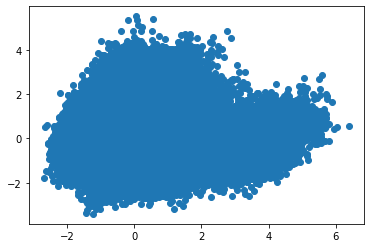

In [13]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

### Create a line plot that shows the explained variance by number of components.

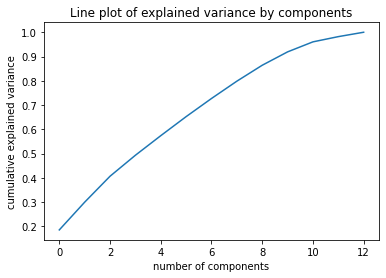

In [14]:
pca_scale = PCA().fit(X_scale)
plt.plot(np.cumsum(pca_scale.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Line plot of explained variance by components')
plt.show()

### Iteratively train and score a Random Forest Classifier (to predict `pitchType`).

* In each iteration:
    * Increase the number of principal components (start with `2`)
    * Store the number of components and model score

In [15]:
model = RandomForestClassifier(max_depth=4, random_state=1)

In [16]:
#split to train and test set for predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

In [17]:
#find scores for components
scores = []
n_components = range(2, len(X.columns))
for i in n_components:
  pca = PCA(n_components=i)
  pca.fit(X_train_scale)
  X_pca = pca.transform(X_train_scale)
  rf = model.fit(X_pca, y_train)
  scores.append(rf.score(X_pca, y_train))
  print(f'RandomForest score for {i} components is: {rf.score(X_pca, y_train)}')

RandomForest score for 2 components is: 0.5860291624279417
RandomForest score for 3 components is: 0.5852492370295015
RandomForest score for 4 components is: 0.5859952526280094
RandomForest score for 5 components is: 0.5855035605289929
RandomForest score for 6 components is: 0.5870634113258731
RandomForest score for 7 components is: 0.5800610376398779
RandomForest score for 8 components is: 0.5688199389623602
RandomForest score for 9 components is: 0.6192946761614107
RandomForest score for 10 components is: 0.6184977958630045
RandomForest score for 11 components is: 0.5999660902000679
RandomForest score for 12 components is: 0.5887589013224822


### Create a line plot that shows the training scores across the different numbers of principal components.

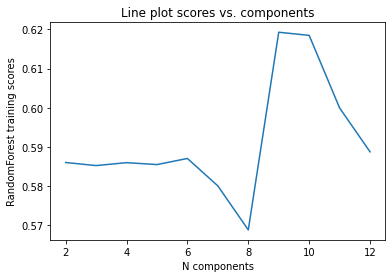

In [19]:
plt.plot(n_components, scores)
plt.xlabel('N components')
plt.ylabel('RandomForest training scores')
plt.title('Line plot scores vs. components')
plt.show()

### Based on the analysis you conducted, what is the optimal number of principal components?

In [20]:
#the optimal number of principal components is 9
#it has 0.62 score which is the highest compared to all